# 0) 라이브러리 import 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from datetime import datetime

matplotlib.rc('font', family = 'Noto Sans CJK JP')
matplotlib.rc('axes', unicode_minus = False)

plt.style.use(['fivethirtyeight'])

import seaborn as sns



from scipy import stats
import scipy.stats
from scipy.stats import shapiro
from scipy.stats import bartlett, levene
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.tools.eval_measures import rmse

from sklearn.tree import export_graphviz

import graphviz
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML


from dask.diagnostics import ProgressBar

display(HTML("<style>.container { width:80% !important; }</style>"))

- 분석배경 : 미세먼지로 인해 건강, 환경, 경제 등 영향을 주면서 다양한 문제를 일으키고 있다. 그래서 대기 중 오염물질과 기상정보를 활용하여 미세먼지 발생/증가에 영향을 미치는 인자를 도출하고 그 영향도를 분석하고자 한다. 다양한 분석을 통해 미세먼지를 유발하는 영향인자를 선정하고, 선정된 영향인자를 활용하여 미세먼지 발생량을 예측하고 대응 방안을 수립하라.

# 0. 데이터 이해 및 전처리(탐색적 데이터 분석)

In [2]:
df = pd.read_csv('/home/piai/test/2. Big Data 분석/AIR_POLLUTION.csv')

In [3]:
df

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.00,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.00,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.00,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.00,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.00,1.45,175,45.5,993.5,0.0,3.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-06-26,19.0,0.039,0.016,0.4,0.003,21.66,0.41,3.12,228,84.0,996.0,0.0,8.73
362,2020-06-27,22.0,0.044,0.017,0.4,0.004,23.94,0.00,1.93,217,69.8,995.8,0.0,6.21
363,2020-06-28,27.0,0.044,0.009,0.4,0.003,25.03,0.00,2.35,283,71.3,994.7,0.0,2.63
364,2020-06-29,36.0,0.026,0.028,0.6,0.003,24.06,1.26,2.48,103,75.5,992.9,0.0,7.58


In [4]:
df.shape

(366, 14)

- 미세먼지 데이터는 366개의 행과 종속변수인 PM10과 나머지 13개의 독립변수로 이루어져있다. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MeasDate   366 non-null    object 
 1   PM10       365 non-null    float64
 2   O3         365 non-null    float64
 3   NO2        365 non-null    float64
 4   CO         311 non-null    float64
 5   SO2        365 non-null    float64
 6   TEMP       366 non-null    float64
 7   RAIN       366 non-null    float64
 8   WIND       366 non-null    float64
 9   WIND_DIR   366 non-null    int64  
 10  HUMIDITY   366 non-null    float64
 11  ATM_PRESS  366 non-null    float64
 12  SNOW       366 non-null    float64
 13  CLOUD      366 non-null    float64
dtypes: float64(12), int64(1), object(1)
memory usage: 40.2+ KB


In [6]:
df.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.000000,365.000000,365.000000,311.000000,365.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,33.421918,0.023600,0.026814,0.517042,0.003033,13.863798,0.381639,2.225301,209.450820,60.295082,1005.848907,0.022951,5.064016
std,15.937983,0.011896,0.010271,0.152820,0.000632,9.830280,1.122127,0.723171,70.735018,14.534983,8.126823,0.222361,2.986119
min,5.000000,0.002000,0.008000,0.300000,0.002000,-7.950000,0.000000,0.940000,50.000000,17.900000,983.800000,0.000000,0.000000
25%,22.000000,0.014000,0.019000,0.400000,0.003000,5.492500,0.000000,1.722500,160.250000,49.650000,999.400000,0.000000,2.510000
50%,31.000000,0.023000,0.025000,0.500000,0.003000,14.000000,0.000000,2.095000,221.000000,61.050000,1006.450000,0.000000,5.310000
75%,42.000000,0.032000,0.034000,0.600000,0.003000,23.070000,0.115000,2.620000,266.000000,69.950000,1011.575000,0.000000,7.570000
max,101.000000,0.062000,0.059000,1.000000,0.005000,31.720000,11.800000,5.880000,351.000000,95.000000,1025.500000,3.200000,10.000000


- PM10, O3, NO2, CO, SO2 에 결측치가 존재하는 것으로 보인다. 이것들을 처리해야한다고 판단된다. 또한 각 변수들 사이에 scale차이가 나기 때문에 이후 모델링을 진행할 때에 스케일링이 필요하다고 판단된다. PM10은 

### 각 피쳐 설명

- 1. MeasDate : 측정일자로 년도-월-일로 구성되어 있으며 이를 처리하기 위해 datatime 라이브러리를 사용해야 한다. 

- 2. PM10 : 미세먼지는  직경에 따라 PM10과 PM2.5등으로 구분하며, PM10은 1000분의 10mm보다 작은 먼지이며, PM2.5는1000분의 2.5mm보다 작은 먼지이다. 미세먼지는 천식과 같은 호흡기계 질병을 악화시키고, 폐 기능의 저하를 초래한다.

- 3. O3 : 오존은 대기 중에 배출된 NOx와 휘발성유기화합물(VOCs) 등이 자외선과 광화학 반응을 일으켜 생성된 PAN, 알데하이드, Acrolein 등의 광화학 옥시던트의 일종으로 2차 오염물질에 속한다. 오존에 반복 노출시에는 폐에 피해를 줄 수 있는데, 가슴의 통증, 기침, 메스꺼움, 목 자극, 소화 등에 영향을 미치며, 기관지염, 심장질환, 폐기종 및 천식을 악화시키고, 폐활량을 감소 시킬 수 있다.

- 4. NO2 : 이산화질소는 적갈색의 반응성이 큰 기체로서, 대기 중에서 일산화질소의 산화에 의해서 발생하며, 대기 중에서 휘발성유기화합물과 반응하여 오존을 생성하는 전구물질(precursor)의 역할을 한다. 고농도에 노출되면 눈, 코 등의 점막에서 만성 기관지염, 폐렴, 폐출혈, 폐수종의 발병으로까지 발전할 수 있는 것으로 보고되고 있다.

- 5. CO : 일산화탄소는 무색, 무취의 유독성 가스로서 연료속의 탄소성분이 불완전 연소되었을 때 발생한다. 혈액순환 중에서 산소운반 역할을 하는 헤모그로빈을 카르복실헤모글로빈(COHb)으로 변성시켜 산소의 운반기능을 저하시키며, 고농도의 일산화탄소는 유독성이 있어 건강한 사람에게도 치명적인 해를 입힌다.

- 6. SO2 : 황산화물의 일종으로 물에 잘 녹는 무색의 자극적인 냄새가 나는 불연성 가스이다. 천연으로는 화산, 온천 등에 존재하며 황화수소와 반응하여 황을 생성한다. 고농도의 아황산가스는 옥외 활동이 많고 천식에 걸린 어른과 어린이에게 일시적으로 호흡장애를 일으킬 수 있으며, 고농도에 폭로될 경우 호흡기계 질환을 일으키고 심장혈관 질환을 악화시키는 것으로 알려져 있다. 



**미세먼지 등급 기준**
- 좋음 (0~30)
- 보통 (31~80)
- 나쁨 (81~150)
- 매우나쁨 (151 이상)

In [7]:
def pm10_rate(x):
    if x >= 150:
        return '매우나쁨'
    elif x >= 80:
        return '나쁨'
    elif x >= 31:
        return '보통'
    else:
        return '좋음'

In [8]:
df['Datetime'] = df['MeasDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [9]:
def holiday(x):
    if x in [5,6]:
        return '1'
    else:
        return '0'

In [10]:
def season(x):
    if x[5:7] in ['06', '07', '08']:
        return 'summer'
    elif x[5:7] in ['03', '04', '05']:
        return 'spring'
    elif x[5:7] in ['02', '01', '12']:
        return 'winter'
    else:
        return 'fall'
        

In [11]:
def win_direct(x):
    if (x >0 and x<=45) or (x > 315):
        return '북'
    elif x > 45 and x < 135:
        return '동'
    elif x > 135 and x < 225:
        return '남'
    else:
        return '서'

In [12]:
## 월 0, 화 1, 수 2...
df['월'] = df['Datetime'].apply(lambda x: x.month)
df['일'] = df['Datetime'].apply(lambda x: x.day)
df['요일'] = df['Datetime'].apply(lambda x: x.weekday())

In [13]:
## 계절
df['season'] = df['MeasDate'].apply(season)

In [14]:
df.loc[0]['MeasDate']

'2019-07-01'

In [15]:
df.loc[365]['MeasDate']

'2020-06-30'

- 1년치 데이터이지만 윤년이기 때문에 1년이 366일임

- 중복된 날짜가 없음

In [16]:
df.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
Datetime      0
월             0
일             0
요일            0
season        0
dtype: int64

In [17]:
## 목표변수인 y값이 결측치여서 이상해서 봐봄

In [18]:
df[df.PM10.isnull()]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Datetime,월,일,요일,season
328,2020-05-24,NaN,NaN,NaN,NaN,NaN,17.48,1.45,2.85,257,83.3,999.4,0.0,8.21,2020-05-24,5,24,6,spring


- 2020년 5월 24일 row에 null 값이 너무 많기 때문에 삭제한다. 

In [19]:
df[df.CO.isnull()]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,Datetime,월,일,요일,season
25,2019-07-26,22.0,0.021,0.027,NaN,0.002,25.06,3.00,1.72,187,94.9,993.9,0.0,9.88,2019-07-26,7,26,4,summer
26,2019-07-27,20.0,0.028,0.025,NaN,0.003,28.10,0.10,1.15,151,78.6,995.6,0.0,8.21,2019-07-27,7,27,5,summer
27,2019-07-28,16.0,0.018,0.019,NaN,0.002,26.31,1.28,2.00,179,87.1,998.0,0.0,9.88,2019-07-28,7,28,6,summer
28,2019-07-29,16.0,0.007,0.017,NaN,0.002,27.42,0.17,2.66,197,75.0,999.3,0.0,8.13,2019-07-29,7,29,0,summer
29,2019-07-30,22.0,0.010,0.019,NaN,0.002,28.04,0.17,3.45,203,75.3,997.2,0.0,8.33,2019-07-30,7,30,1,summer
30,2019-07-31,20.0,0.016,0.025,NaN,0.002,25.87,3.11,2.30,195,91.3,998.9,0.0,9.58,2019-07-31,7,31,2,summer
31,2019-08-01,15.0,0.014,0.020,NaN,0.002,26.41,2.25,1.70,237,85.8,1001.8,0.0,7.42,2019-08-01,8,1,3,summer
32,2019-08-02,19.0,0.020,0.020,NaN,0.002,28.38,0.00,1.26,185,74.8,1001.9,0.0,4.04,2019-08-02,8,2,4,summer
33,2019-08-03,21.0,0.033,0.029,NaN,0.002,29.40,1.00,1.36,152,70.6,1001.1,0.0,4.29,2019-08-03,8,3,5,summer
34,2019-08-04,29.0,0.042,0.030,NaN,0.003,28.46,2.87,1.21,165,73.4,1001.0,0.0,5.50,2019-08-04,8,4,6,summer


In [20]:
df = df.drop(328).reset_index(drop=True)

- 모든 CO의 결측값을 제거하기에는 2019년 7월말부터 8월 전체, 9월 중순까지의 전체 데이터가 삭제되기 때문에 해당 기간에 대한  너무 많은 데이터 손실이 일어나기 때문에 대체하는 방법을 택함.

In [21]:
temp_df = df.dropna()

<AxesSubplot:xlabel='월', ylabel='CO'>

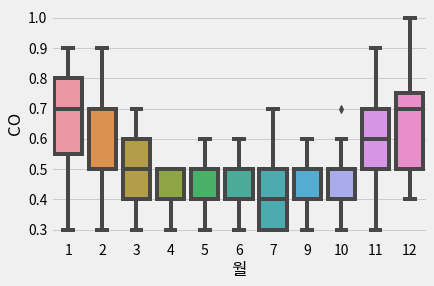

In [22]:
sns.boxplot(x = '월', y = 'CO', data = temp_df)

- 기존의 여름이라고 생각되는 6,7,8월의 평균 값으로 일산화탄소를 대체하려 하였지만 8월에 모든 데이터가 결측이고 7월은 6일, 9월은 17일 분량의 데이터가 결측이기 때문에 데이터의 일반화를 위해 6월과 분포가 비슷한 5월과 9월과 분포가 비슷한 10월의 값 또한 평균값 대체에 사용하여 결측 CO 데이터의 일반화를 위해 노력한다.

In [23]:
month_list = [5,6,7,9,10]
df['CO'] = df['CO'].fillna(df.query('월 in @month_list')['CO'].mean())

In [24]:
df.isnull().sum()

MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
Datetime     0
월            0
일            0
요일           0
season       0
dtype: int64

--------------------------------------------------


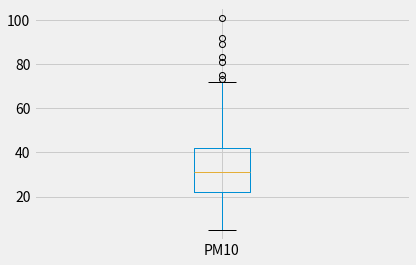



--------------------------------------------------


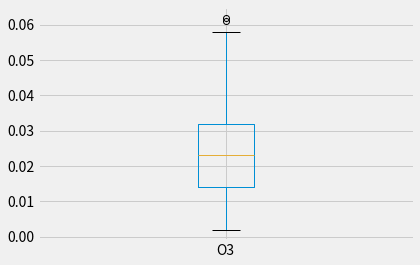



--------------------------------------------------


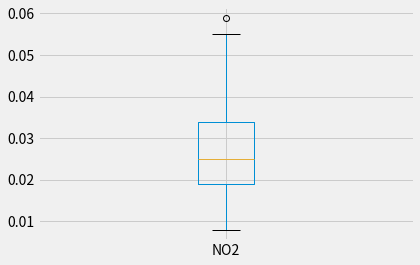



--------------------------------------------------


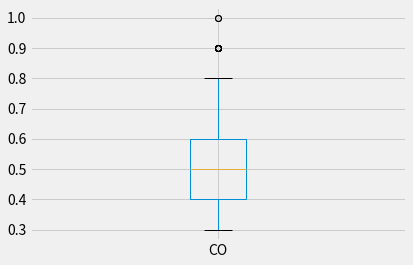



--------------------------------------------------


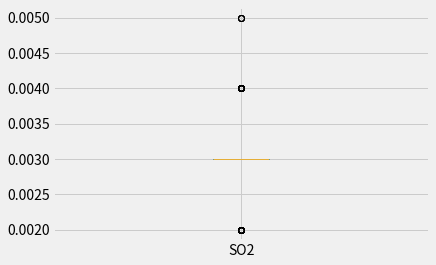



--------------------------------------------------


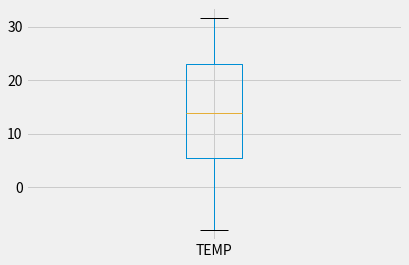



--------------------------------------------------


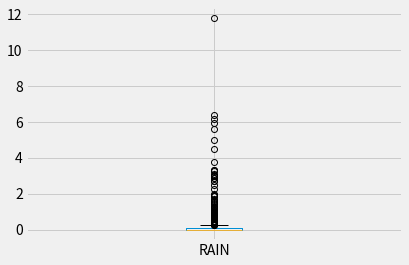



--------------------------------------------------


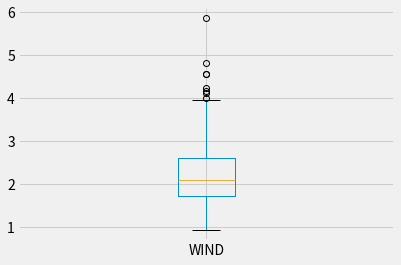



--------------------------------------------------


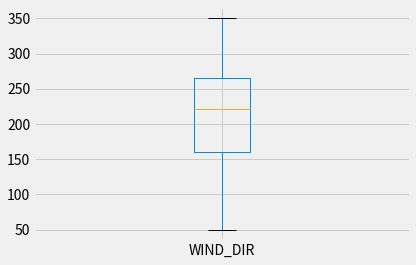



--------------------------------------------------


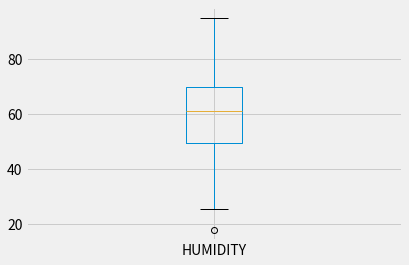



--------------------------------------------------


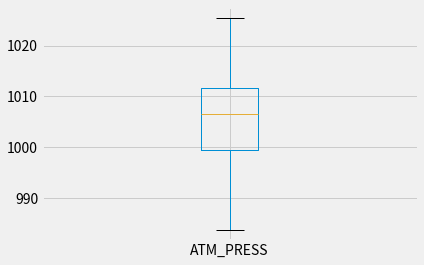



--------------------------------------------------


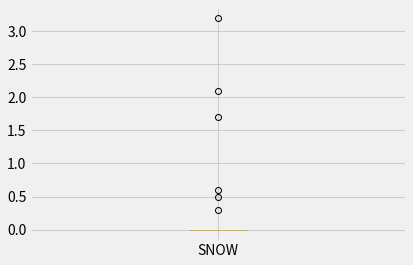



--------------------------------------------------


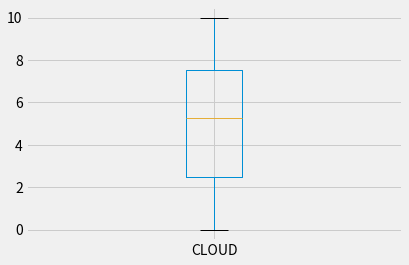

In [25]:
for i in list(df.columns)[1:len(df.columns)-5]:
    print('-'*50)
    df[[i]].boxplot()
    plt.show()
    print()
    print()

- 이상치가 딱히 존재하지 않는다. SO2는 연속형 변수지만 이산형으로 표현된다. 하지만 이 값을 범주화하기에는 무리가 있다고 판단된다. 
- 비 또는 눈이 오지 않는 날이 많아 이를 처리해야겠다고 판단하였고 다음과 같은 방법을 채택하였다.
- RAIN은 범주형으로 바꿔줘야된다. 강수여부라는 새로운 파생변수를 생성
- SNOW 같은 경우에도 동일하게 눈이 온 날이 6일 뿐이기 때문에 강설여부라는 파생변수 생성 

In [26]:
df['주말여부'] = df['요일'].apply(holiday)
df['강수여부'] = df['RAIN'].apply(lambda x : '0' if x == 0 else '1')
df['강설여부'] = df['SNOW'].apply(lambda x : '0' if x == 0 else '1')
df['월'] = df['월'].astype('str')
df['일'] = df['일'].astype('str')
df['요일'] = df['요일'].astype('str')
df['풍향'] = df['WIND_DIR'].apply(win_direct)

In [27]:
df = df.drop(['MeasDate','SNOW', 'RAIN', 'WIND_DIR' ,'Datetime'], axis=1)

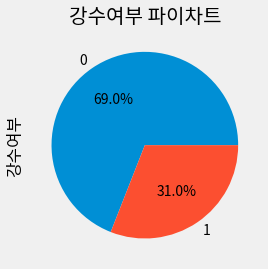

In [28]:
df['강수여부'].value_counts().plot.pie(autopct='%.1f%%')
plt.title('강수여부 파이차트')
plt.show()

- 비가 오는 날이 일년중 30% 정도 인 것을 확인 할 수 있다. 유의미한 변수가 될 수 있을 것이라 판단된다. 

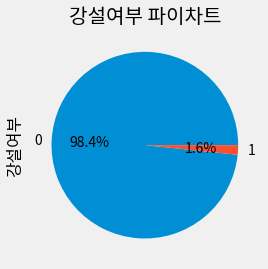

In [29]:
df['강설여부'].value_counts().plot.pie(autopct='%.1f%%')
plt.title('강설여부 파이차트')
plt.show()

- 일년 중 눈이 오는 날이 1.6%, 6일 밖에 되지 않는다. 그렇기 유의미한 독립변수가 될 수 있을거라 판단하지 않는다.

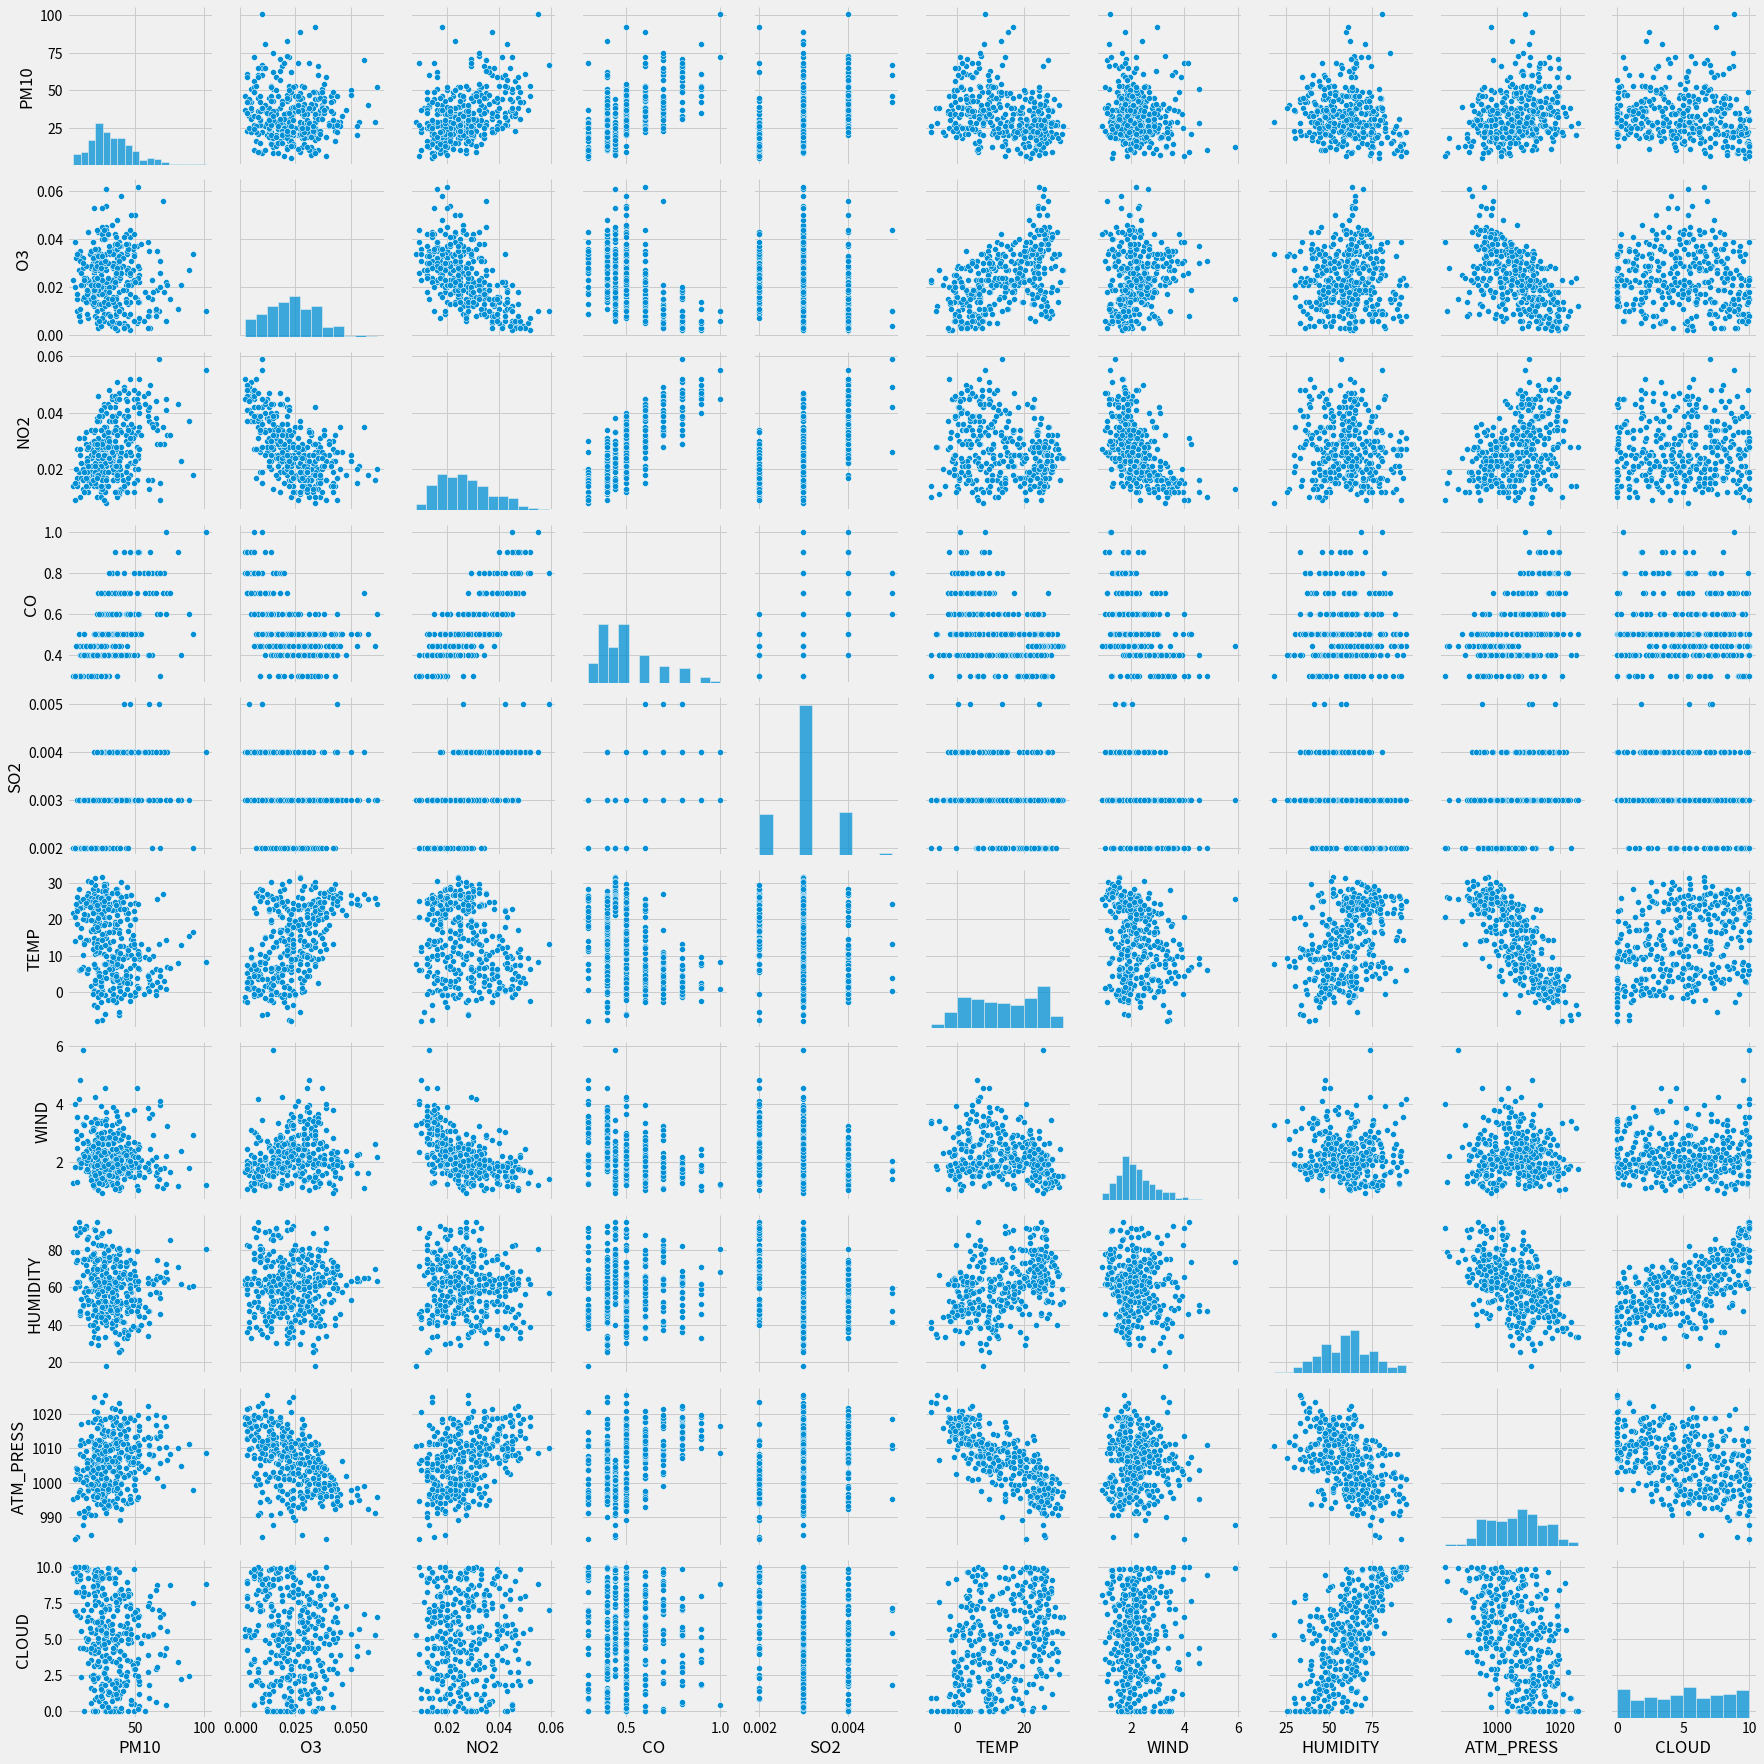

In [30]:
# 수치형 변수에 대한 Pair plot
sns.pairplot(df)

- 위의 pair plot을 보면 

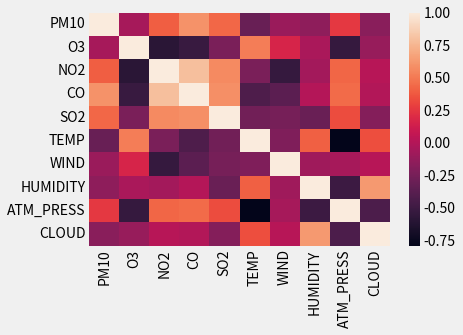

In [31]:
# 수치형 변수에 대한 상관계수 및 heatmap
sns.heatmap(df.corr())
plt.show()

In [32]:
df.corr()

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
PM10,1.000000,-0.051763,0.395969,0.593998,0.428685,-0.309786,-0.100323,-0.149803,0.253023,-0.172230
O3,-0.051763,1.000000,-0.591658,-0.520024,-0.234127,0.516257,0.165216,-0.037699,-0.534372,-0.119307
NO2,0.395969,-0.591658,1.000000,0.796859,0.563432,-0.237406,-0.536649,-0.065514,0.420292,0.016722
CO,0.593998,-0.520024,0.796859,1.000000,0.586156,-0.426461,-0.370458,0.001012,0.445380,-0.006661
SO2,0.428685,-0.234127,0.563432,0.586156,1.000000,-0.273629,-0.252864,-0.302278,0.333995,-0.191234
TEMP,-0.309786,0.516257,-0.237406,-0.426461,-0.273629,1.000000,-0.216042,0.404147,-0.792079,0.341553
WIND,-0.100323,0.165216,-0.536649,-0.370458,-0.252864,-0.216042,1.000000,-0.084299,-0.053769,0.016841
HUMIDITY,-0.149803,-0.037699,-0.065514,0.001012,-0.302278,0.404147,-0.084299,1.000000,-0.510358,0.627970
ATM_PRESS,0.253023,-0.534372,0.420292,0.445380,0.333995,-0.792079,-0.053769,-0.510358,1.000000,-0.429744
CLOUD,-0.172230,-0.119307,0.016722,-0.006661,-0.191234,0.341553,0.016841,0.627970,-0.429744,1.000000


# 2. 통계적 추론(정규성 검정, 등분산성 검정, 2-sample t-test, ANOVA)

- The Importance of the Normality Assumption in Large Public Health Data Sets

- Abstract : It is widely but incorrectly believed that the t-test and linear regression are valid only for Normally distributed outcomes. The t-test and linear regression compare the mean of an outcome variable for different subjects. While these are valid even in very small samples if the outcome variable is Normally distributed, their major usefulness comes from the fact that in large samples they are valid for any distribution. We demonstrate this validity by simulation in extremely non-Normal data. We discuss situations in which in other methods such as the Wilcoxon rank sum test and ordinal logistic regression (proportional odds model) have been recommended, and conclude that the t-test and linear regression often provide a convenient and practical alternative. The major limitation on the t-test and linear regression for inference about associations is not a distributional one, but whether detecting and estimating a difference in the mean of the outcome answers the scientific question at hand.

 -> 요약: t-test와 선형회귀가 정규성을 지닌 표본에서만 유효하다는 믿음이 있지만 이는 사실이 아니다. t-test와 선형회귀는 다른 집단의 평균을 비교하는 것이다. 정규성을 지닐 때만 유효한 것은 표본의 크기가 작을 때이다. 표본의 크기가 크다면 어느 분포에서 나온 표본들에서도 t-test가 유효하다. 극단적으로 정규분포가 아닐때도 유효하다는 것을 주장하고 있다.

-> 궁금한건 각 변수들에 따라서 미세먼지의 평균차이가 있는지?  
-> 모집단의 표준편차를 모른다..  
-> t-test  

# 2 sample t-test
- 분석절차
1. 정규성 검정(shapiro)
2. 등분산성 검정 -> 정규분포를 따를때: Bartlett, 안따를때 : Levene
3. 평균검정(2 sample t-test) -> 등분산일때 student's t, 등분산 아닐때 welch's

In [33]:
df.iloc[:,1:-8]

,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70
1,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83
2,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29
3,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54
4,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92
...,...,...,...,...,...,...,...,...,...
360,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73
361,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21
362,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63
363,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58


## 2 sample t-test (수치형 변수)  

In [34]:
for i in list(df.iloc[:,1:-8].columns):
    print(i,' 의 통계적 추론')
    print()
    Temp_low = pd.DataFrame({'PM10' : df[df[i] > df[i].mean()]['PM10']}).reset_index(drop=True)
    Temp_high = pd.DataFrame({'PM10' : df[df[i] <= df[i].mean()]['PM10']}).reset_index(drop=True)
    
    ## 정규성
    print('*** 정규성 검정 ***')
    print()
    normality_1, normality_p_1 = stats.shapiro(Temp_high)
    normality_2, normality_p_2 = stats.shapiro(Temp_low)

    print('평균보다 높은 집단의 \n정규성 검정 검정통계량 :{}, \np-value :{}'.format(normality_1, normality_p_1))
    print()
    print('평균보다 낮거나 같은 집단의 \n정규성 검정 검정통계량 :{}, \np-value :{}'.format(normality_2, normality_p_2))

    print()
    print('-'*20)
    
    if (normality_p_1 >= 0.05) & (normality_p_2>= 0.05): ## 두 집단 모두 정규성을 띈다.
        print('*** 등분산성 검정 ***')
      ## 등분산성
        Equal_variance, Equal_variance_p = stats.bartlett(Temp_high['PM10'], Temp_low['PM10'])

        print('등분산성 검정 \n검정 검정통계량 :{}, \np-value :{}'.format(Equal_variance, Equal_variance_p))  

        print()
        print('-'*20)

        if Equal_variance_p >= 0.05: #등분산일 때
            ## 2-sample t-test
            t_result = stats.ttest_ind(Temp_high['PM10'], Temp_low['PM10'], equal_var=True)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
    
            print('*'*40)
        else: # 등분산이 아닐때
            ## 2-sample t-test
            t_result = stats.ttest_ind(Temp_high['PM10'], Temp_low['PM10'], equal_var=False)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
    
            print('*'*40)
    else: # 두집단 중 하나라도 정규성을 띄지 않는다면
        print('*** 등분산성 검정 ***')
          ## 등분산성
        Equal_variance, Equal_variance_p = stats.levene(Temp_high['PM10'], Temp_low['PM10'])

        print('등분산성 검정 \n검정 검정통계량 :{}, \np-value :{}'.format(Equal_variance, Equal_variance_p))  

        print()
        print('-'*20)
        if Equal_variance_p >= 0.05: #등분산일 때
            ## 2-sample t-test
            t_result = stats.ttest_ind(Temp_high['PM10'], Temp_low['PM10'], equal_var=True)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
    
            print('*'*40)
        else: # 등분산이 아닐때
            ## 2-sample t-test
            t_result = stats.ttest_ind(Temp_high['PM10'], Temp_low['PM10'], equal_var=False)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
    
            print('*'*40)

O3  의 통계적 추론

*** 정규성 검정 ***

평균보다 높은 집단의 
정규성 검정 검정통계량 :0.947780430316925, 
p-value :1.8096500298270257e-06

평균보다 낮거나 같은 집단의 
정규성 검정 검정통계량 :0.9478341341018677, 
p-value :5.438265816337662e-06

--------------------
*** 등분산성 검정 ***
등분산성 검정 
검정 검정통계량 :5.380238444472293, 
p-value :0.020920368096532128

--------------------
*** 2-sample t-test ***
t 검정통계량 : 1.016
p-value : 0.31

****************************************
NO2  의 통계적 추론

*** 정규성 검정 ***

평균보다 높은 집단의 
정규성 검정 검정통계량 :0.9386135935783386, 
p-value :2.0810654177694232e-07

평균보다 낮거나 같은 집단의 
정규성 검정 검정통계량 :0.9599791765213013, 
p-value :9.566208609612659e-05

--------------------
*** 등분산성 검정 ***
등분산성 검정 
검정 검정통계량 :5.097715972097549, 
p-value :0.024550825770740706

--------------------
*** 2-sample t-test ***
t 검정통계량 : -6.259
p-value : 0.0

****************************************
CO  의 통계적 추론

*** 정규성 검정 ***

평균보다 높은 집단의 
정규성 검정 검정통계량 :0.9447208642959595, 
p-value :2.0156262436898942e-08

평균보다 낮거나 같은 집단의 
정규성 검정 검정통계량 :0.9530749917030334

- O3(오존)의 2-sample t-test의 p-value를 확인해보았을 때 0.31로 0.05보다 크기 때문에 O3에 따른 미세먼지의 평균에 차이가 없는 것으로 보임

- NO2의 2-sample t-test의 p-value를 확인해보았을 때 0.0로 0.05보다 작기 때문에 NO에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

- CO의 2-sample t-test의 p-value를 확인해보았을 때 0.0로 0.05보다 작기 때문에 NO에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

- SO2의 2-sample t-test의 p-value를 확인해보았을 때 0.0로 0.05보다 작기 때문에 SO2에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

- TEMP의 2-sample t-test의 p-value를 확인해보았을 때 0.0로 0.05보다 작기 때문에 TEMP(온도)에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

- WIND의 2-sample t-test의 p-value를 확인해보았을 때 0.059로 0.05보다 크기 때문에 WIND(풍속)에 따른 미세먼지의 평균에 차이가 없는 것으로 보임

- HUMIDITY의 2-sample t-test의 p-value를 확인해보았을 때 0.634로 0.05보다 크기 때문에 HUMIDITY(습도)에 따른 미세먼지의 평균에 차이가 없는 것으로 보임

- ATM_PRESS의 2-sample t-test의 p-value를 확인해보았을 때 0.0로 0.05보다 작기 때문에 ATM_PRESS(기압)에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

- CLOUD의 2-sample t-test의 p-value를 확인해보았을 때 0.034로 0.05보다 작기 때문에 CLOUD(전운량)에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

## 2 sample t-test (범주형 변수)  

In [35]:
for i in ['주말여부', '강수여부', '강설여부']:
    print(i,' 의 통계적 추론')
    print()
    temp_0 = pd.DataFrame({'PM10': df[df[i] == '0']['PM10']}).reset_index(drop=True)
    temp_1 = pd.DataFrame({'PM10': df[df[i] == '1']['PM10']}).reset_index(drop=True)
    print('*** 정규성 검정 ***')
    print()

    normality_1, normality_p_1 = stats.shapiro(temp_0)
    normality_2, normality_p_2 = stats.shapiro(temp_1)

    print('평균보다 높은 집단의 \n정규성 검정 검정통계량 :{}, \np-value :{}'.format(normality_1, normality_p_1))
    print()
    print('평균보다 낮거나 같은 집단의 \n정규성 검정 검정통계량 :{}, \np-value :{}'.format(normality_2, normality_p_2))

    print()

    if (normality_p_1 >= 0.05) & (normality_p_2>= 0.05): ## 두 집단 모두 정규성을 띈다.
        print('*** 등분산성 검정 ***')
      ## 등분산성
        Equal_variance, Equal_variance_p = stats.bartlett(temp_0['PM10'], temp_1['PM10'])

        print('등분산성 검정 \n검정 검정통계량 :{}, \np-value :{}'.format(Equal_variance, Equal_variance_p))  

        print()
        if Equal_variance_p >= 0.05: #등분산일 때
            ## 2-sample t-test
            t_result = stats.ttest_ind(temp_0['PM10'], temp_1['PM10'], equal_var=True)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
            print('-'* 60)            
        else: # 등분산이 아닐때
            ## 2-sample t-test
            t_result = stats.ttest_ind(temp_0['PM10'], temp_1['PM10'], equal_var=False)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
            print('-'* 60)            
    else: # 두집단 중 하나라도 정규성을 띄지 않는다면
        print('*** 등분산성 검정 ***')
          ## 등분산성
        Equal_variance, Equal_variance_p = stats.levene(temp_0['PM10'], temp_1['PM10'])

        print('등분산성 검정 \n검정 검정통계량 :{}, \np-value :{}'.format(Equal_variance, Equal_variance_p))  

        print()
        if Equal_variance_p >= 0.05: #등분산일 때
            ## 2-sample t-test
            t_result = stats.ttest_ind(temp_0['PM10'], temp_1['PM10'], equal_var=True)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
            print('-'* 60)            
        else: # 등분산이 아닐때
            ## 2-sample t-test
            t_result = stats.ttest_ind(temp_0['PM10'], temp_1['PM10'], equal_var=False)
            t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

            print('*** 2-sample t-test ***')
            print('t 검정통계량 :', t)  
            print('p-value :', p)
            print()
            print('-'* 60)

주말여부  의 통계적 추론

*** 정규성 검정 ***

평균보다 높은 집단의 
정규성 검정 검정통계량 :0.9372698664665222, 
p-value :4.042686185812272e-09

평균보다 낮거나 같은 집단의 
정규성 검정 검정통계량 :0.9632505178451538, 
p-value :0.005849056877195835

*** 등분산성 검정 ***
등분산성 검정 
검정 검정통계량 :0.2310989708699359, 
p-value :0.6309997541208274

*** 2-sample t-test ***
t 검정통계량 : -0.317
p-value : 0.751

------------------------------------------------------------
강수여부  의 통계적 추론

*** 정규성 검정 ***

평균보다 높은 집단의 
정규성 검정 검정통계량 :0.9625291228294373, 
p-value :3.7925456126686186e-06

평균보다 낮거나 같은 집단의 
정규성 검정 검정통계량 :0.8876467347145081, 
p-value :9.800134392889959e-08

*** 등분산성 검정 ***
등분산성 검정 
검정 검정통계량 :1.1403029696864806, 
p-value :0.28629795077341624

*** 2-sample t-test ***
t 검정통계량 : 2.904
p-value : 0.004

------------------------------------------------------------
강설여부  의 통계적 추론

*** 정규성 검정 ***

평균보다 높은 집단의 
정규성 검정 검정통계량 :0.9501688480377197, 
p-value :1.1793275245253199e-09

평균보다 낮거나 같은 집단의 
정규성 검정 검정통계량 :0.7293481826782227, 
p-value :0.01241486705839634

*** 등

- 주말여부의 2-sample t-test의 p-value를 확인해보았을 때 0.751로 0.05보다 크기 때문에 주말여부에 따른 미세먼지의 평균에 차이가 없는 것으로 보임

- 강수여부의 2-sample t-test의 p-value를 확인해보았을 때 0.004로 0.05보다 작기 때문에 강수여부에 따른 미세먼지의 평균에 차이가 있는 것으로 보임

- 강설여부의 2-sample t-test의 p-value를 확인해보았을 때 0.826로 0.05보다 크기 때문에 강설여부에 따른 미세먼지의 평균에 차이가 없는 것으로 보임

## ANOVA

### 계절

In [36]:
df['season'].unique()

array(['summer', 'fall', 'winter', 'spring'], dtype=object)

In [37]:
temp_sum = df[df['season'] == 'summer']['PM10']

temp_fall = df[df['season'] == 'fall']['PM10']

temp_spri = df[df['season'] == 'spring']['PM10']

temp_win = df[df['season'] == 'winter']['PM10']

f_result =stats.f_oneway(temp_spri, temp_sum, temp_fall, temp_win)

f, p = f_result.statistic.round(5), f_result.pvalue.round(5)

print('f 검정 통계량 : ',f)
print('p-value : ',p)

f 검정 통계량 :  17.81743
p-value :  0.0


- 계절에 따른 분산분석을 진행해본 결과 p-value가 0.0이므로 계절간 미세먼지 평균농도에 차이가 있는 것으로 보임

### 월

In [38]:
df['월'].unique()

array(['7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5', '6'],
      dtype=object)

In [39]:
temp_1 = df[df['월'] == '1']['PM10']

temp_2 = df[df['월'] == '2']['PM10']

temp_3 = df[df['월'] == '3']['PM10']

temp_4 = df[df['월'] == '4']['PM10']

temp_5 = df[df['월'] == '5']['PM10']

temp_6 = df[df['월'] == '6']['PM10']

temp_7 = df[df['월'] == '7']['PM10']

temp_8 = df[df['월'] == '8']['PM10']

temp_9 = df[df['월'] == '9']['PM10']

temp_10 = df[df['월'] == '10']['PM10']

temp_11 = df[df['월'] == '11']['PM10']

temp_12 = df[df['월'] == '12']['PM10']


f_result =stats.f_oneway(temp_1, temp_2, temp_3, temp_4, temp_5, temp_6,
                         temp_7, temp_8, temp_9, temp_10, temp_11, temp_12)

f, p = f_result.statistic.round(5), f_result.pvalue.round(5)

print('f 검정 통계량 : ',f)
print('p-value : ',p)

f 검정 통계량 :  7.75577
p-value :  0.0


- 월에 따른 분산분석을 진행해본 결과 p-value가 0.0이므로 월(month)간 미세먼지 평균농도에 차이가 있는 것으로 보임

### 요일

In [40]:
temp_1 = df[df['요일'] == '1']['PM10']

temp_2 = df[df['요일'] == '2']['PM10']

temp_3 = df[df['요일'] == '3']['PM10']

temp_4 = df[df['요일'] == '4']['PM10']

temp_5 = df[df['요일'] == '5']['PM10']

temp_6 = df[df['요일'] == '0']['PM10']

f_result =stats.f_oneway(temp_1, temp_2, temp_3, temp_4, temp_5, temp_6)

f, p = f_result.statistic.round(5), f_result.pvalue.round(5)

print('f 검정 통계량 : ',f)
print('p-value : ',p)

f 검정 통계량 :  0.34282
p-value :  0.88667


- 요일에 따른 분산분석을 진행해본 결과 p-value가 0.88667으로 0.05보다 크므로 요일간 미세먼지 평균농도에 차이가 없는 것으로 보임

## 풍향

In [41]:
temp_1 = df[df['풍향'] == '북']['PM10']

temp_2 = df[df['풍향'] == '동']['PM10']

temp_3 = df[df['풍향'] == '서']['PM10']

temp_4 = df[df['풍향'] == '남']['PM10']

f_result =stats.f_oneway(temp_1, temp_2, temp_3, temp_4)

f, p = f_result.statistic.round(5), f_result.pvalue.round(5)

print('f 검정 통계량 : ',f)
print('p-value : ',p)

f 검정 통계량 :  6.568
p-value :  0.00025


- 풍향에 따른 분산분석을 진행해본 결과 p-value가 0.00025으로 0.05보다 작으므로 풍향간 미세먼지 평균농도에 차이가 있는 것으로 보임

# 상관분석

In [42]:
df.iloc[:,1:10]

,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70
1,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83
2,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29
3,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54
4,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92
...,...,...,...,...,...,...,...,...,...
360,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73
361,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21
362,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63
363,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58


In [43]:
for i in df.iloc[:,1:10].columns:
    print(i,'변수와 미세먼지간에 상관관계')
    df_Y = df['PM10']
    df_x = df[i]

    corr, pval = stats.pearsonr(df_Y, df_x)
    print('*** Correlation Analysis ***')
    print('corr:{0:0.3f}'.format(corr))
    print('p-value : {0:0.3f}'.format(pval))
    print('-'*30)

O3 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:-0.052
p-value : 0.324
------------------------------
NO2 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:0.396
p-value : 0.000
------------------------------
CO 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:0.594
p-value : 0.000
------------------------------
SO2 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:0.429
p-value : 0.000
------------------------------
TEMP 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:-0.310
p-value : 0.000
------------------------------
WIND 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:-0.100
p-value : 0.056
------------------------------
HUMIDITY 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:-0.150
p-value : 0.004
------------------------------
ATM_PRESS 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:0.253
p-value : 0.000
------------------------------
CLOUD 변수와 미세먼지간에 상관관계
*** Correlation Analysis ***
corr:-0.172
p-value : 0.001
------------------------------


- PM10과 다른 수치형 변수들끼리 상관분석을 진행해본 결과 p-value가 0.05보다 작은 변수들은 NO2, CO, SO2, TEMP, HUMIDITY, ATM_PRESS, CLOUD가 있다. 하지만 상관계수를 보면 SO2와 CO, NO2 정도가 약한 상관이 있다고 보인다.

# 회귀분석

In [44]:
## test size 비율에 대한 변환은 데이터 수가 적어 0.2로 설정했는데 마음대로 하셔도 될 듯 합니다.
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (292, 18)
test data size : (73, 18)


In [45]:
df

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,월,일,요일,season,주말여부,강수여부,강설여부,풍향
0,29.0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70,7,1,0,summer,0,0,0,서
1,26.0,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83,7,2,1,summer,0,0,0,서
2,30.0,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29,7,3,2,summer,0,0,0,서
3,28.0,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54,7,4,3,summer,0,0,0,서
4,29.0,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92,7,5,4,summer,0,0,0,남
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,19.0,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73,6,26,4,summer,0,1,0,서
361,22.0,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21,6,27,5,summer,1,0,0,남
362,27.0,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63,6,28,6,summer,1,0,0,서
363,36.0,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58,6,29,0,summer,0,1,0,동


In [46]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + TEMP + WIND + HUMIDITY + ATM_PRESS + CLOUD + C(월) + C(요일) + C(season) + C(주말여부) + C(강수여부) + C(강설여부) + C(풍향)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     12.24
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           2.74e-35
Time:                        00:02:05   Log-Likelihood:                -1086.9
No. Observations:                 292   AIC:                             2238.
Df Residuals:                     260   BIC:                             2356.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              54.5773    

## 후진제거법으로 변수제거

- 월 변수 제거

In [47]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + TEMP + WIND + HUMIDITY + ATM_PRESS + CLOUD  + C(요일) + C(season) + C(주말여부) + C(강수여부) + C(강설여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     14.34
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           5.18e-32
Time:                        00:02:05   Log-Likelihood:                -1112.9
No. Observations:                 292   AIC:                             2268.
Df Residuals:                     271   BIC:                             2345.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -125.8823    

- 요일 변수 제거

In [48]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + TEMP + WIND + HUMIDITY + ATM_PRESS + CLOUD + C(season) + C(주말여부) + C(강수여부) + C(강설여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     18.88
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           3.14e-34
Time:                        00:02:05   Log-Likelihood:                -1115.2
No. Observations:                 292   AIC:                             2262.
Df Residuals:                     276   BIC:                             2321.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -152.8564    

- HUMIDITY(습도) 제거

In [49]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + TEMP + WIND + CLOUD + ATM_PRESS + C(season) + C(주말여부) + C(강수여부) + C(강설여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     20.29
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           6.97e-35
Time:                        00:02:06   Log-Likelihood:                -1115.2
No. Observations:                 292   AIC:                             2260.
Df Residuals:                     277   BIC:                             2316.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -139.5542    

- TEMP(온도) 제거

In [50]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + WIND + CLOUD + ATM_PRESS + C(season) + C(주말여부) + C(강수여부) + C(강설여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     21.89
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.68e-35
Time:                        00:02:06   Log-Likelihood:                -1115.4
No. Observations:                 292   AIC:                             2259.
Df Residuals:                     278   BIC:                             2310.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -190.9733    

- 주말여부 제거

In [51]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + WIND + CLOUD + ATM_PRESS + C(season) + C(강수여부) + C(강설여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     23.71
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           4.29e-36
Time:                        00:02:07   Log-Likelihood:                -1115.7
No. Observations:                 292   AIC:                             2257.
Df Residuals:                     279   BIC:                             2305.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -197.2860    

- ATM_PRESS 변수 제거

In [52]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + WIND + CLOUD + C(season) + C(강수여부) + C(강설여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     25.77
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.33e-36
Time:                        00:02:08   Log-Likelihood:                -1116.2
No. Observations:                 292   AIC:                             2256.
Df Residuals:                     280   BIC:                             2300.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -34.1001    

- 강설여부 변수제거

In [53]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + NO2 + CO + SO2 + WIND + CLOUD + C(season) + C(강수여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     28.35
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           3.09e-37
Time:                        00:02:09   Log-Likelihood:                -1116.4
No. Observations:                 292   AIC:                             2255.
Df Residuals:                     281   BIC:                             2295.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -33.9732    

- NO2 변수 제거

In [54]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + CO + SO2 + WIND + CLOUD + C(season) + C(강수여부)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     31.22
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           1.26e-37
Time:                        00:02:10   Log-Likelihood:                -1117.4
No. Observations:                 292   AIC:                             2255.
Df Residuals:                     282   BIC:                             2291.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -31.1190    

- 강수여부 변수 제거

In [55]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + CO + SO2 + WIND + CLOUD + C(season)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     34.87
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           4.29e-38
Time:                        00:02:10   Log-Likelihood:                -1118.1
No. Observations:                 292   AIC:                             2254.
Df Residuals:                     283   BIC:                             2287.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -31.2150    

- SO2 변수 제거

In [56]:
reg_model = smf.ols(formula = 'PM10 ~ O3 + CO + WIND + CLOUD + C(season)', data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     39.32
Date:                Wed, 01 Jun 2022   Prob (F-statistic):           2.12e-38
Time:                        00:02:12   Log-Likelihood:                -1119.4
No. Observations:                 292   AIC:                             2255.
Df Residuals:                     284   BIC:                             2284.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -27.8080    

- p-value가 매우 작은 값이므로 회귀모델이 유의하다. 해당 모델은 다중회귀모형으로 수정된 결정계수를 확인해보면 전체데이터의 48.0%를 설명할 수 있다.

- 최종모델의 회귀식
- : Y(미세먼지) = -27.8080 + 9.3918*(계절_봄) + 416.7329*O3(오존) + 88.8225*CO(일산화탄소) + 2.6840*WIND(풍속) - 0.6287*CLOUD

- 미세먼지의 농도에는 계절적 요인(봄)과 오존, 일산화탄소, 풍속등, 전운량이 영향을 미치는 것을 알 수 있다. 

- 봄일 때 미세먼지의 농도가 9.3918 증가하고 오존농도가 1 증가하면 미세먼지농도가 416.732 증가하고 일산화탄소 농도가 1 증가하면 미세먼지의 농도가 88.822증가하고 풍속이 1(m/s)증가하면 미세먼지농도가 2.6840 증가하고 전운량이 1 증가하면 미세먼지 농도가 0.6287 감소한다고 판단 할 수 있다. 

In [57]:
df_train_x = df_train[['O3','CO' ,'WIND' ,'CLOUD']]
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values,i) for i in range(df_train_x_const.shape[1])]

df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

/home/piai/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,variable,VIF
4,CLOUD,1.011
3,WIND,1.147
1,O3,1.362
2,CO,1.518
0,const,63.776


- 모든 변수가 다중공선성이 10이하이다. 다중공선성이 없다고 판단한다.

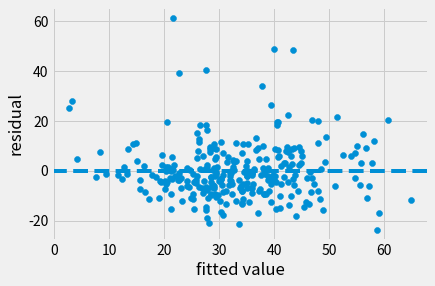

In [58]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel('fitted value')
plt.ylabel('residual')
plt.axhline(y=0,linestyle='--')
plt.show()

/home/piai/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


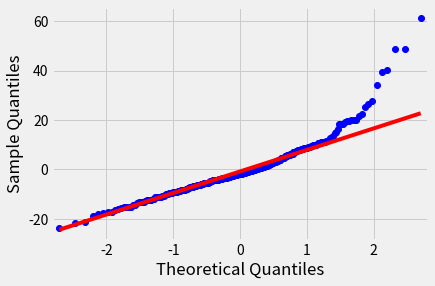

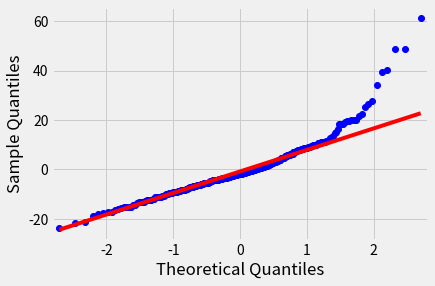

In [59]:
qqplot(reg_result.resid, line='q')

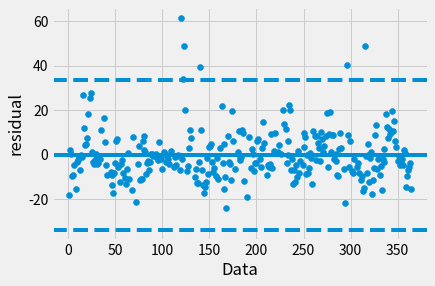

In [60]:
plt.scatter(df_train.index, reg_result.resid, marker='o')
plt.xlabel('Data')
plt.ylabel('residual')
plt.axhline(y=0, linestyle='-')
plt.axhline(y = 3*np.std(reg_result.resid), linestyle = '--')
plt.axhline(y = -3*np.std(reg_result.resid), linestyle = '--')
plt.show()

In [61]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)

print('train data의 결정계수:', r2_score(df_train['PM10'], train_pred))
print('test data의 결정계수:', r2_score(df_test['PM10'], test_pred))

train data의 결정계수: 0.49214577095723455
test data의 결정계수: 0.645359674819618


# 모델링 - 의사결정나무

In [62]:
df

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,월,일,요일,season,주말여부,강수여부,강설여부,풍향
0,29.0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70,7,1,0,summer,0,0,0,서
1,26.0,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83,7,2,1,summer,0,0,0,서
2,30.0,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29,7,3,2,summer,0,0,0,서
3,28.0,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54,7,4,3,summer,0,0,0,서
4,29.0,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92,7,5,4,summer,0,0,0,남
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,19.0,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73,6,26,4,summer,0,1,0,서
361,22.0,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21,6,27,5,summer,1,0,0,남
362,27.0,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63,6,28,6,summer,1,0,0,서
363,36.0,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58,6,29,0,summer,0,1,0,동


In [63]:
df = df.drop('일', axis=1)

- 회귀식에서 월, 요일이 유의미하지 않다고 나왔기 때문에 해당 칼럼들을 삭제하고 모델링을 진행한다. 데이터의 크기에 비해 월, 요일을 모두 one-hot encoding을 진행하면 input data가 sparse해져서 성능이 낮을 것이라고 판단되어 이를 제거한다.

In [65]:
df

,PM10,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,월,요일,season,주말여부,강수여부,강설여부,풍향
0,29.0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70,7,0,summer,0,0,0,서
1,26.0,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83,7,1,summer,0,0,0,서
2,30.0,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29,7,2,summer,0,0,0,서
3,28.0,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54,7,3,summer,0,0,0,서
4,29.0,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92,7,4,summer,0,0,0,남
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,19.0,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73,6,4,summer,0,1,0,서
361,22.0,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21,6,5,summer,1,0,0,남
362,27.0,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63,6,6,summer,1,0,0,서
363,36.0,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58,6,0,summer,0,1,0,동


In [66]:
df_raw_y = df['PM10']
df_raw_x = df.drop(['PM10','월','요일', '풍향'], axis=1, inplace=False)

In [67]:
df_raw_x = pd.get_dummies(df_raw_x)

In [68]:
df_raw_x

,O3,NO2,CO,SO2,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,season_fall,season_spring,season_summer,season_winter,주말여부_0,주말여부_1,강수여부_0,강수여부_1,강설여부_0,강설여부_1
0,0.054,0.021,0.5,0.003,24.03,2.30,63.2,995.1,5.70,0,0,1,0,1,0,1,0,1,0
1,0.053,0.020,0.5,0.003,24.29,2.26,63.2,998.6,3.83,0,0,1,0,1,0,1,0,1,0
2,0.042,0.023,0.4,0.003,24.18,1.79,65.3,998.3,6.29,0,0,1,0,1,0,1,0,1,0
3,0.034,0.026,0.4,0.003,25.35,2.04,58.6,996.6,2.54,0,0,1,0,1,0,1,0,1,0
4,0.045,0.035,0.5,0.003,27.30,1.45,45.5,993.5,3.92,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.039,0.016,0.4,0.003,21.66,3.12,84.0,996.0,8.73,0,0,1,0,1,0,0,1,1,0
361,0.044,0.017,0.4,0.004,23.94,1.93,69.8,995.8,6.21,0,0,1,0,0,1,1,0,1,0
362,0.044,0.009,0.4,0.003,25.03,2.35,71.3,994.7,2.63,0,0,1,0,0,1,1,0,1,0
363,0.026,0.028,0.6,0.003,24.06,2.48,75.5,992.9,7.58,0,0,1,0,1,0,0,1,1,0


In [69]:
## train data와 test data를 0.8,0.2비율로 나눈다.
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size=0.2, random_state=1234)

print('train data X size :{}'.format(df_train_x.shape))
print('train data Y size :{}'.format(df_train_y.shape))
print('test data X size :{}'.format(df_test_x.shape))
print('test data Y size :{}'.format(df_test_y.shape))

train data X size :(292, 19)
train data Y size :(292,)
test data X size :(73, 19)
test data Y size :(73,)


- Grid Search로 최적의 파라미터를 찾고자 함
- 이 때에 Grid search가 기본적으로 KFold를 통해 최적의 모델을 찾는데 이때 default는 5인데 훈련데이터의 개수가 적기 때문에 최대한 많은 비율의 데이터를 학습에 사용하기 위해 10으로 높혀 grid search를 돌린다.

In [70]:
para_depth = [i for i in range(1,11)]
para_split = [i*2 for i in range(2,20)]
para_leaf = [i for i in range(1,10)]

In [71]:
estimator = DecisionTreeRegressor(random_state = 1234)

param_grid = {'criterion' : ['squared_error', 'absolute_error', 'friedman_mse'],
             'max_features' : ['sqrt', 'log2'],
             'max_depth' : para_depth,
             'min_samples_split' : para_split,
             'min_samples_leaf' : para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='r2', n_jobs=-1, cv=10)
grid_dt.fit(df_train_x, df_train_y)

scores_df = pd.DataFrame(grid_dt.cv_results_)
scores_df[['params', 'mean_test_score','rank_test_score',
           'split0_test_score', 'split1_test_score', 'split2_test_score']].sort_values(by = 'rank_test_score')

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
2377,"{'criterion': 'squared_error', 'max_depth': 8,...",0.347428,1,0.455971,0.385374,0.392736
8861,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",0.347428,1,0.455971,0.385374,0.392736
9020,"{'criterion': 'friedman_mse', 'max_depth': 8, ...",0.347428,1,0.455971,0.385374,0.392736
2381,"{'criterion': 'squared_error', 'max_depth': 8,...",0.347428,1,0.455971,0.385374,0.392736
2380,"{'criterion': 'squared_error', 'max_depth': 8,...",0.347428,1,0.455971,0.385374,0.392736
...,...,...,...,...,...,...
2916,"{'criterion': 'squared_error', 'max_depth': 10...",-0.189098,9715,-0.103113,0.121510,0.285910
9396,"{'criterion': 'friedman_mse', 'max_depth': 10,...",-0.189098,9715,-0.103113,0.121510,0.285910
9558,"{'criterion': 'friedman_mse', 'max_depth': 10,...",-0.189098,9715,-0.103113,0.121510,0.285910
6156,"{'criterion': 'absolute_error', 'max_depth': 1...",-0.210272,9719,0.183322,-0.176132,-0.652674


In [72]:
print('best estimator model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print()
print()
print('\nbest train_dataset score: {}'.format(grid_dt.best_score_.round(3)))
print('\nbest test_dataset score: {}'.format(grid_dt.best_estimator_.score(df_test_x, df_test_y).round(3)))

best estimator model: 
DecisionTreeRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=4, random_state=1234)

best parameter: 
{'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 4}



best train_dataset score: 0.347

best test_dataset score: 0.292


In [73]:
v_feature_name = df_train_x.columns

In [74]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = grid_dt.best_estimator_.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.550
5,WIND,0.109
0,O3,0.091
6,HUMIDITY,0.066
8,CLOUD,0.059
4,TEMP,0.037
11,season_summer,0.029
9,season_fall,0.025
15,강수여부_0,0.013
1,NO2,0.013


Text(0, 0.5, '변수')

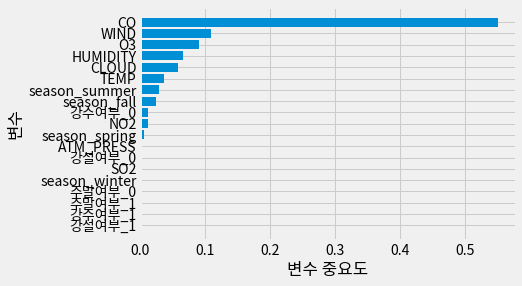

In [75]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 모델링 - Random Foreset

In [76]:
para_n_esti = [n_tree * 10 for n_tree in range(1,11)]
para_depth = [i for i in range(1,11)]
para_split = [i*2 for i in range(2,20)]
para_leaf = [i for i in range(1,10)]

In [80]:
estimator = RandomForestRegressor(random_state = 1234)

param_random = {'criterion' : ['squared_error', 'absolute_error'],
             'max_depth' : para_depth,
             'min_samples_split' : para_split,
             'min_samples_leaf' : para_leaf,
             'n_estimators' : para_n_esti}

random_rf = RandomizedSearchCV(estimator, param_random, scoring='r2', n_jobs=-1, cv=10, n_iter=1000 )
random_rf.fit(df_train_x, df_train_y)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=1234),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [4, 6, 8, 10, 12,
                                                              14, 16, 18, 20,
                                                              22, 24, 26, 28,
                                                              30, 32, 34, 36,
                                                              38],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   scoring='r2')

In [81]:
print('best estimator model: \n{}'.format(random_rf.best_estimator_))
print('\nbest parameter: \n{}'.format(random_rf.best_params_))
print()
print()
print('\nbest train_dataset score: {}'.format(random_rf.best_score_.round(3)))
print('\nbest test_dataset score: {}'.format(random_rf.best_estimator_.score(df_test_x, df_test_y).round(3)))

best estimator model: 
RandomForestRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=50, random_state=1234)

best parameter: 
{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 8, 'criterion': 'squared_error'}



best train_dataset score: 0.501

best test_dataset score: 0.568


In [82]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = random_rf.best_estimator_.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.429
0,O3,0.145
10,season_spring,0.071
5,WIND,0.067
8,CLOUD,0.064
6,HUMIDITY,0.050
4,TEMP,0.044
1,NO2,0.041
7,ATM_PRESS,0.040
9,season_fall,0.026


Text(0, 0.5, '변수')

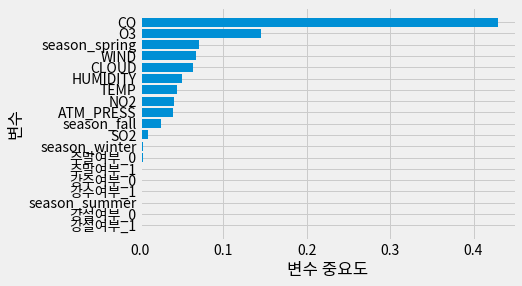

In [83]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 모델링 - Gradient Boosting

- gradient boosting은 모델학습시간이 오래걸리므로 random search를 사용하여 최적의 파라미터를 찾고자한다.

In [84]:
para_n_esti = [n_tree * 10 for n_tree in range(1,11)]
para_depth = [i for i in range(1,11)]
para_split = [i*2 for i in range(2,20)]
para_leaf = [i for i in range(1,10)]
para_lr = [lr * 0.1 for lr in range(1,10)]

In [85]:
estimator = GradientBoostingRegressor(random_state = 1234)

param_random = {
             'max_features' : ['sqrt', 'log2'],
             'max_depth' : para_depth,
             'min_samples_split' : para_split,
             'min_samples_leaf' : para_leaf,
             'n_estimators' : para_n_esti,
             'learning_rate' : para_lr}

rand_GB = RandomizedSearchCV(estimator, param_random, scoring='r2', n_jobs=-1, cv=10, n_iter=2000)
rand_GB.fit(df_train_x, df_train_y)

RandomizedSearchCV(cv=10,
                   estimator=GradientBoostingRegressor(random_state=1234),
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
                                                          0.8, 0.9],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [4, 6, 8, 10, 12,
                                                              14, 16, 18, 20,
                                                              22, 24, 26, 28,
                                                              30, 32, 34, 36,
                                                              38],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   scoring='r2')

In [86]:
print('best estimator model: \n{}'.format(rand_GB.best_estimator_))
print('\nbest parameter: \n{}'.format(rand_GB.best_params_))
print()
print()
print('\nbest train_dataset score: {}'.format(rand_GB.best_score_.round(3)))
print('\nbest test_dataset score: {}'.format(rand_GB.best_estimator_.score(df_test_x, df_test_y).round(3)))

best estimator model: 
GradientBoostingRegressor(max_depth=5, max_features='log2', min_samples_leaf=5,
                          min_samples_split=18, random_state=1234)

best parameter: 
{'n_estimators': 100, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}



best train_dataset score: 0.505

best test_dataset score: 0.516


In [87]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rand_GB.best_estimator_.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.274
0,O3,0.111
4,TEMP,0.093
6,HUMIDITY,0.091
5,WIND,0.080
8,CLOUD,0.079
1,NO2,0.076
3,SO2,0.054
7,ATM_PRESS,0.053
10,season_spring,0.026


Text(0, 0.5, '변수')

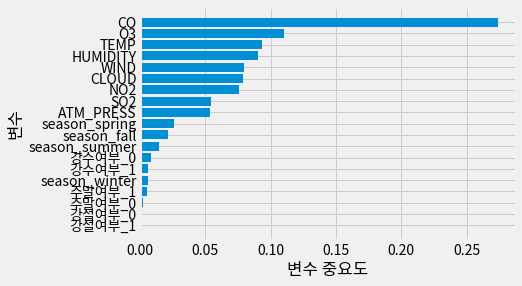

In [88]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 모델링 - XGBoost

In [89]:
import xgboost

In [97]:
para_depth = [i for i in range(1,11)]
para_bytree = [i*0.1 for i in range(1,10)]
para_subsam = [i*0.1 for i in range(1,10)]
para_n_esti = [n_tree * 10 for n_tree in range(1,11)]
gamma_list = [i*0.1 for i in range(1,10)]
para_lr = [lr * 0.1 for lr in range(1,10)]


In [98]:
estimator = xgboost.XGBRegressor(random_state = 1234)

param_random = {
             'max_depth' : para_depth,
             'colsample_bytree' : para_bytree,
             'subsample' : para_subsam,
             'n_estimators' : para_n_esti,
               'gamma' : gamma_list,
                'learning_rate' :para_lr}

random_xgb = RandomizedSearchCV(estimator, param_random, scoring='r2', n_jobs=-1, cv=10, n_iter=4000 )
random_xgb.fit(df_train_x, df_train_y)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,...
                                        'gamma': [0.1, 0.2, 0.30000000000000004,
                                                  0.4, 0.5, 0.6000000000000001,
                                                  0.7000000000000001, 0.8,
                                                  0.9],
                                        'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
                                                          0.8, 0.9],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100],
                                        'subsample': [0.1, 0.2,
                                                      0.30000000000000004, 0.4,
                                                      0.5, 0.6000000000000001,
                                                      0.7000000000000001, 0.8,
                                                      0.9]},
                   scoring='r2')

In [99]:
print('best estimator model: \n{}'.format(random_xgb.best_estimator_))
print('\nbest parameter: \n{}'.format(random_xgb.best_params_))
print()
print()
print('\nbest train_dataset score: {}'.format(random_xgb.best_score_.round(3)))
print('\nbest test_dataset score: {}'.format(random_xgb.best_estimator_.score(df_test_x, df_test_y).round(3)))

best estimator model: 
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7000000000000001, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0.4, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=1234, reg_alpha=0, reg_lambda=1, ...)

best parameter: 
{'subsample': 0.8, 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7000000000000001}



best train_dataset score: 0.504

best test_dataset score: 0.474


In [100]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rand_GB.best_estimator_.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
2,CO,0.274
0,O3,0.111
4,TEMP,0.093
6,HUMIDITY,0.091
5,WIND,0.080
8,CLOUD,0.079
1,NO2,0.076
3,SO2,0.054
7,ATM_PRESS,0.053
10,season_spring,0.026


Text(0, 0.5, '변수')

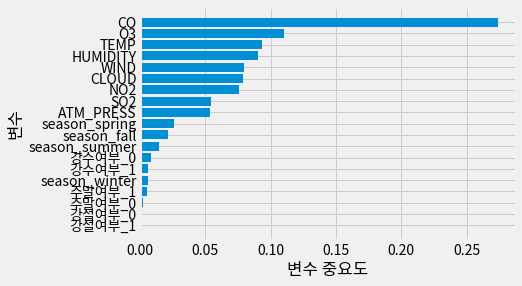

In [101]:
df_importance.sort_values('Importance', ascending=True, inplace =True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# 모델 평가 및 선정(predict)

In [156]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [226]:
models = ['다중회귀분석','의사결정나무', '랜덤 포레스트', '그래디언트 부스팅', 'XGBoost']

mse, rmse, mae, mape = [],[],[],[]

In [227]:
test_pred = reg_result.predict(df_test)

mse.append(mean_squared_error(df_test_y, test_pred))
rmse.append(root_mean_squared_error(df_test_y, test_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, test_pred))

In [228]:
dt_y_pred = grid_dt.best_estimator_.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [229]:
rf_y_pred = random_rf.best_estimator_.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [230]:
gb_y_pred = rand_GB.best_estimator_.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

In [231]:
xgb_y_pred = random_xgb.best_estimator_.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, xgb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, xgb_y_pred))
mae.append(mean_absolute_error(df_test_y, xgb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, xgb_y_pred))

In [232]:
plt.rc('xtick', labelsize=10)

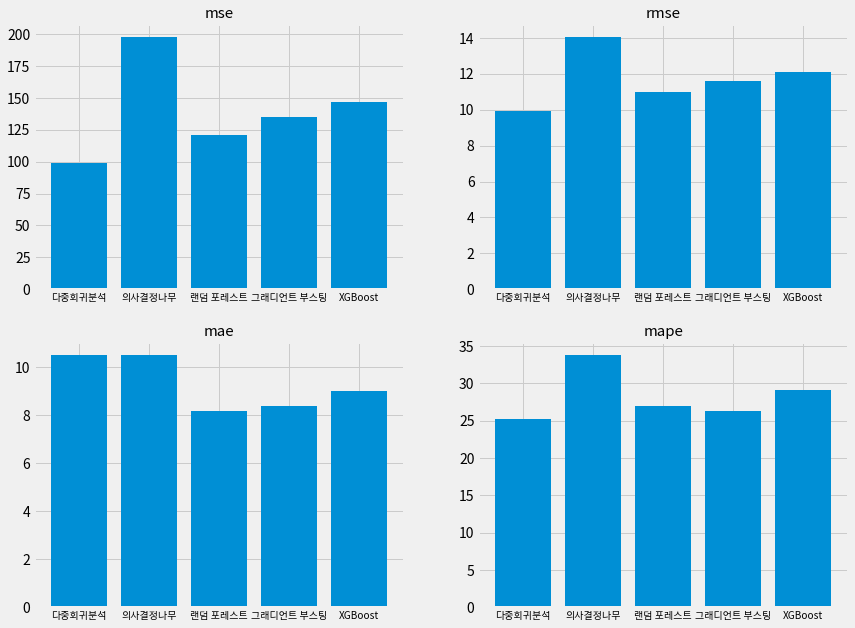

In [233]:
fig, ax = plt.subplots(2,2, figsize =(13,10))
ax[0,0].bar(models, mse)
ax[0,0].set_title('mse').set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title('rmse').set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title('mae').set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title('mape').set_fontsize(15)

# 인사이트 도출

In [183]:
seoul_dust = pd.read_excel('/home/piai/다운로드/2020_06_airpollution.xls').iloc[1:,:]

In [214]:
seoul_air = pd.read_csv('/home/piai/다운로드/OBS_ASOS_TIM_20220601021920.csv', encoding='cp949')

In [215]:
our_data = pd.read_csv('/home/piai/test/2. Big Data 분석/AIR_POLLUTION.csv')

In [216]:
our_data[our_data['MeasDate'].str.contains('2020-06')]

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
336,2020-06-01,18.0,0.035,0.015,0.3,0.002,19.84,0.20,3.38,288,65.2,999.7,0.0,4.42
337,2020-06-02,22.0,0.024,0.029,0.4,0.003,17.90,0.63,2.11,189,69.0,997.9,0.0,8.75
338,2020-06-03,43.0,0.042,0.019,0.5,0.002,21.84,0.10,2.38,233,73.4,994.1,0.0,5.42
339,2020-06-04,45.0,0.036,0.017,0.4,0.002,21.91,0.02,2.68,266,79.9,994.0,0.0,8.04
340,2020-06-05,39.0,0.037,0.020,0.4,0.002,22.86,0.00,1.96,270,71.5,997.1,0.0,5.96
341,2020-06-06,50.0,0.050,0.023,0.5,0.003,24.58,0.00,1.98,183,63.6,998.0,0.0,2.92
342,2020-06-07,42.0,0.041,0.014,0.4,0.003,22.87,0.00,2.34,266,68.5,1001.6,0.0,3.88
343,2020-06-08,38.0,0.037,0.021,0.4,0.003,24.78,0.00,2.14,240,65.5,1004.5,0.0,2.79
344,2020-06-09,43.0,0.038,0.025,0.4,0.003,26.60,0.00,2.25,246,52.4,1004.4,0.0,2.42
345,2020-06-10,40.0,0.026,0.028,0.4,0.003,26.07,1.00,2.09,235,60.0,999.7,0.0,8.50


In [217]:
seoul_dust

,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
1,2020-06-01,18,10,0.035,0.015,0.3,0.002
2,2020-06-02,22,15,0.024,0.029,0.4,0.003
3,2020-06-03,43,24,0.042,0.019,0.5,0.002
4,2020-06-04,45,26,0.036,0.017,0.4,0.002
5,2020-06-05,39,21,0.037,0.02,0.4,0.002
6,2020-06-06,50,32,0.05,0.023,0.5,0.003
7,2020-06-07,42,27,0.041,0.014,0.4,0.003
8,2020-06-08,38,22,0.037,0.021,0.4,0.003
9,2020-06-09,43,24,0.038,0.025,0.4,0.003
10,2020-06-10,40,24,0.026,0.028,0.4,0.003


In [223]:
seoul_air['일시'] = seoul_air['일시'].apply(lambda x: x[:-6])

In [224]:
seoul_air.groupby('일시')['기온(°C)'].mean().reset_index()

,일시,기온(°C)
0,2020-06-01,19.939130
1,2020-06-02,17.900000
2,2020-06-03,21.841667
3,2020-06-04,21.908333
4,2020-06-05,22.862500
5,2020-06-06,24.583333
6,2020-06-07,22.870833
7,2020-06-08,24.775000
8,2020-06-09,26.604167
9,2020-06-10,26.066667


- 해당 데이터는 에어코리아의 서울 중구의 미세먼지, 오존, 이산화질소, 일산화탄소 데이터와 기상청 기상자료개방포털에서 서울특별시 중 서울 측정지에서 시간대별 기온, 강수량, 풍속, 풍향, 습도, 현지기압, 적설량, 전운량의 데이터를 합친 것이다. 이것으로 서울지역 미세먼지에 대한 인사이트를 도출하고자 한다.

- 다중선형회귀모델, 파라미터 튜닝한 의사결정나무, 랜덤포레스트, 그레디언트 부스팅, XGBoost 모델들의 공통점은 모두 미세먼지의 농도에는 CO, O3의 영향이 크다는 것이다. 또한 봄에 미세먼지의 농도가 높은 것을 확인 할 수 있다.  

- 추가적인 결론 및 대안은 ppt에 첨부하겠습니다.